In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import scanpy as sc 
import seaborn as sns 
import pymn 
import anndata as ad
from tqdm import tqdm

In [3]:
adata = sc.read_h5ad('/home/rsun@ZHANGroup.local/sly_data/data/final_anno.h5ad')
print(adata.shape)

(338818, 3000)


In [4]:
def tissue_pipe(adata):
    tissue_keylist = ['BQ','CT','HM','NG','PC','QN','XQ','YB']
    species_keylist = ['CY','JT','T','QF','M']

    """
    data sample
    """
    sel_data_list = []
    for tissue_key in tissue_keylist:
        subdata = adata[adata.obs.tissues == tissue_key]

        for species_key in species_keylist:
            scdata = subdata[subdata.obs.species == species_key].raw.to_adata()

            idx = np.arange(scdata.shape[0])
            sel_idx = np.random.choice(idx, size = 1000)
            scdata = scdata[sel_idx]
            
            sel_data_list.append(scdata)

    scdata = ad.concat(sel_data_list)
    scdata.obs_names_make_unique()
    scdata.obs.tissues = scdata.obs.tissues.astype(str)
    scdata.obs.species = scdata.obs.species.astype(str) 

    """
    score calculation
    """

    pymn.variableGenes(scdata, study_col = 'species')
    pymn.MetaNeighborUS(scdata,
                        study_col='species',
                        ct_col='tissues',
                        fast_version=True)
    tissue_res = {}
    df = scdata.uns['MetaNeighborUS']
    for tissue_key in tissue_keylist:
        sel_columns = [f'{species_key}|{tissue_key}' for species_key in species_keylist]
        res_df = df.loc[sel_columns, sel_columns]

        mu_1 = res_df.iloc[:3,:3].mean().mean()
        mu_2 = res_df.iloc[3:,3:].mean().mean()
        mu_d = res_df.iloc[3:,:3].mean().mean()
        tissue_res[tissue_key] =(mu_1 + mu_2)/2 - mu_d

    return tissue_res 

def tissue_estimation(N=25):
    res = []
    for i in tqdm(range(N)):
        res.append(tissue_pipe_1(adata))
    return res

def tissue_pipe_1(adata):
    tissue_keylist = ['BQ','CT','HM','NG','PC','QN','XQ','YB']
    species_keylist = ['CY','JT','T','QF','M']

    """
    data sample
    """
    tissue_res = {}
    for tissue_key in tissue_keylist:
        subdata = adata[adata.obs.tissues == tissue_key]
        centroid_list = []
        for species_key in species_keylist:
            scdata = subdata[subdata.obs.species == species_key]#.raw.to_adata()

            idx = np.arange(scdata.shape[0])
            sel_idx = np.random.choice(idx, size = 1000)
            meta_cell = scdata[sel_idx].obsm['X_pca_harmony'].mean(axis = 0)
            #meta_cell = scdata[sel_idx].X.toarray().mean(axis = 0)
            
            centroid_list.append(meta_cell)
    
        centroid_data = np.array(centroid_list)
        tmp = np.corrcoef(centroid_data)
        a1 = (tmp[:3,:3].sum() - 3)/6
        a2 = (tmp[3:,3:].sum() - 2)/2
        a3 = (tmp[3:,:3]).sum()/6 
        score = (a1+a2)/2 - a3
        tissue_res[tissue_key] = score

    ### add tissue random data
    centroid_list = [] 
    for species_key in species_keylist:
        #scdata = adata[adata.obs.species == species_key]#.raw.to_adata()

        idx = np.arange(adata.shape[0])
        sel_idx = np.random.choice(idx, size = 1000)
        meta_cell = adata[sel_idx].obsm['X_pca_harmony'].mean(axis = 0)
        #meta_cell = adata[sel_idx].X.toarray().mean(axis = 0)
        centroid_list.append(meta_cell)
    
    centroid_data = np.array(centroid_list)
    tmp = np.corrcoef(centroid_data)
    a1 = (tmp[:3,:3].sum() - 3)/6
    a2 = (tmp[3:,3:].sum() - 2)/2
    a3 = (tmp[3:,:3]).sum()/6 
    score = (a1+a2)/2 - a3
    tissue_res['random'] = score 


    return tissue_res 

In [5]:
res = tissue_estimation(N = 50)
df = pd.DataFrame(res)


ori_col = np.array(df.columns)
new_col = []
for ele in ori_col:
    if ele == 'random':
        continue 
    else:
        new_col.append(ele)
new_col.append('random')

df = df[new_col]
df.to_csv('tissues_score.csv')

100%|██████████| 50/50 [01:43<00:00,  2.07s/it]


/tmp/ipykernel_2934495/1818400808.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='Group', y='Value', data=df_melted, palette="Set3")


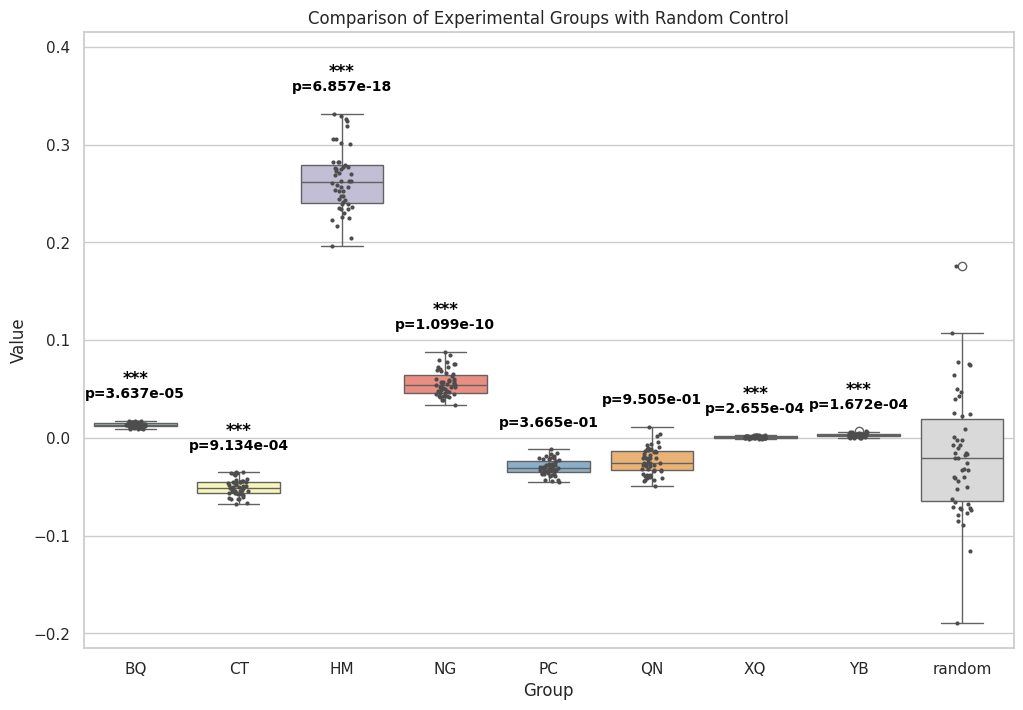

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums


# 对照组数据位于第9列（索引为8）
control_group = df.iloc[:, 8]

# 存储结果
results = []

# 循环遍历前8列实验组数据（索引0到7）
for i in range(8):
    experiment_group = df.iloc[:, i]
    # 执行秩和检验
    stat, p_value = ranksums(experiment_group, control_group)
    results.append({'Column': df.columns[i], 'Statistic': stat, 'P-value': p_value})

# 将结果转换为 DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv('tissue_score_p_value.csv')

# 设置绘图风格
sns.set(style="whitegrid")

# 创建一个新的DataFrame用于绘图
df_melted = df.iloc[:, :9].melt(id_vars=[], value_vars=[f'{df.columns[i]}' for i in range(9)],
                                var_name='Group', value_name='Value')

# 绘制箱线图并获取轴对象
plt.figure(figsize=(12, 8))
box_plot = sns.boxplot(x='Group', y='Value', data=df_melted, palette="Set3")

# 添加散点图以显示原始数据点，并减小点的大小
sns.stripplot(x='Group', y='Value', data=df_melted, color=".3", jitter=True, size=3)  # 减小点的大小

# 计算位置信息并添加 p 值和显著性标记
positions = range(len(df.columns)-1)  # 获取分组数量
for idx, result in enumerate(results_df.itertuples()):
    p_value = result[3]
    if p_value < 0.001:
        significance = "***"
    elif p_value < 0.01:
        significance = "**"
    elif p_value < 0.05:
        significance = "*"
    else:
        significance = ""

    # 使用 box_plot 数据计算上边缘位置
    group_data = df[df.columns[idx]]
    q1, med, q3 = group_data.quantile([0.25, 0.5, 0.75])
    upper_whisker = min(q3 + 1.5 * (q3 - q1), group_data.max())

    # 在箱子的上边缘之上一点添加 p 值
    box_plot.text(positions[idx], upper_whisker + (box_plot.get_ylim()[1] - box_plot.get_ylim()[0]) * 0.04,
                  f"p={p_value:.3e}", horizontalalignment='center', size='small', color='black', weight='semibold')
    
    # 在 p 值之上添加显著性标记
    box_plot.text(positions[idx], upper_whisker + (box_plot.get_ylim()[1] - box_plot.get_ylim()[0]) * 0.065,
                  significance, horizontalalignment='center', size='medium', color='black', weight='bold')

# 调整y轴范围确保文本不会超出图像边界
box_plot.set_ylim(box_plot.get_ylim()[0], box_plot.get_ylim()[1] + (box_plot.get_ylim()[1] - box_plot.get_ylim()[0]) * 0.1)

# 显示图形
plt.title('Comparison of Experimental Groups with Random Control')
plt.show()

In [14]:
hmdata = sc.read_h5ad('hmdata_full_harmony.h5ad') 
hmdata

AnnData object with n_obs × n_vars = 36611 × 3000
    obs: 'species', 'tissues', 'samples', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cluster', 'celltype', 'coarse_celltype'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'cluster_colors', 'coarse_celltype_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'samples_colors', 'species_colors', 'tissues_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'harmony_0', 'umap_0'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [15]:
hmdata = sc.read_h5ad('hmdata_full_harmony.h5ad')

total_res = []

for i in tqdm(range(50)):
    species_keylist = ['CY','JT','T','QF','M']
    celltype_list = hmdata.obs.celltype.unique()

    """
    data sample
    """
    res = {}
    for celltype_key in celltype_list:
        subdata = hmdata[hmdata.obs.celltype == celltype_key]
        centroid_list = []
        for species_key in species_keylist:
            scdata = subdata[subdata.obs.species == species_key]#.raw.to_adata()

            idx = np.arange(scdata.shape[0])
            sel_idx = np.random.choice(idx, size = 100)

            meta_cell = scdata[sel_idx,:].obsm['X_pca_harmony'].mean(axis = 0)
            meta_cell = scdata[sel_idx,:].X.toarray().mean(axis = 0)
            centroid_list.append(meta_cell)

        centroid_data = np.array(centroid_list)
        tmp = np.corrcoef(centroid_data)
        a1 = (tmp[:3,:3].sum() - 3)/6
        a2 = (tmp[3:,3:].sum() - 2)/2
        a3 = (tmp[3:,:3]).sum()/6 
        score = (a1+a2)/2 - a3
        res[celltype_key] = score 


        ### add celltype random control 
        centroid_list = []
        for species_key in species_keylist:
            scdata = hmdata[hmdata.obs.species == species_key]#.raw.to_adata()

            idx = np.arange(scdata.shape[0])
            sel_idx = np.random.choice(idx, size = 100)

            meta_cell = scdata[sel_idx,:].obsm['X_pca_harmony'].mean(axis = 0)
            #meta_cell = scdata[sel_idx,:].X.toarray().mean(axis = 0)
            centroid_list.append(meta_cell)

        centroid_data = np.array(centroid_list)
        tmp = np.corrcoef(centroid_data)
        a1 = (tmp[:3,:3].sum() - 3)/6
        a2 = (tmp[3:,3:].sum() - 2)/2
        a3 = (tmp[3:,:3]).sum()/6 
        score = (a1+a2)/2 - a3
        res['random'] = score 
    total_res.append(res)

100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


In [16]:
df = pd.DataFrame(total_res)

ori_col = np.array(df.columns)
new_col = []
for ele in ori_col:
    if ele == 'random':
        continue 
    else:
        new_col.append(ele)
new_col.append('random')

df = df[new_col]
df.to_csv('celltype_raw_score.csv')
df

,excitatory neuron,OPC,inhibitory neuron,astrocyte,microglia,oligodendrocyte,ependymal,random
0,0.059495,0.048348,0.054055,0.023062,-0.008607,0.027348,0.044877,0.115600
1,0.053243,0.044445,0.056174,0.027399,-0.009958,0.032365,0.044398,0.310426
2,0.052521,0.049457,0.054765,0.026650,-0.009698,0.037938,0.035762,0.073353
3,0.052912,0.046740,0.052965,0.030296,-0.006777,0.025639,0.041479,0.252375
4,0.055556,0.045972,0.055320,0.026670,-0.012254,0.029206,0.032320,0.287918
5,0.053893,0.048385,0.053847,0.022986,-0.006845,0.031917,0.031601,0.654087
6,0.052912,0.043610,0.056066,0.026681,-0.012077,0.033632,0.021637,0.199632
7,0.053264,0.047759,0.053037,0.028127,-0.006801,0.024322,0.026520,0.037662
8,0.049346,0.047979,0.055143,0.028528,-0.009481,0.039312,0.044347,0.123120
9,0.051580,0.049948,0.051837,0.028950,-0.010287,0.030380,0.038089,0.218333


/tmp/ipykernel_2934495/3782359494.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='Group', y='Value', data=df_melted, palette="Set3")


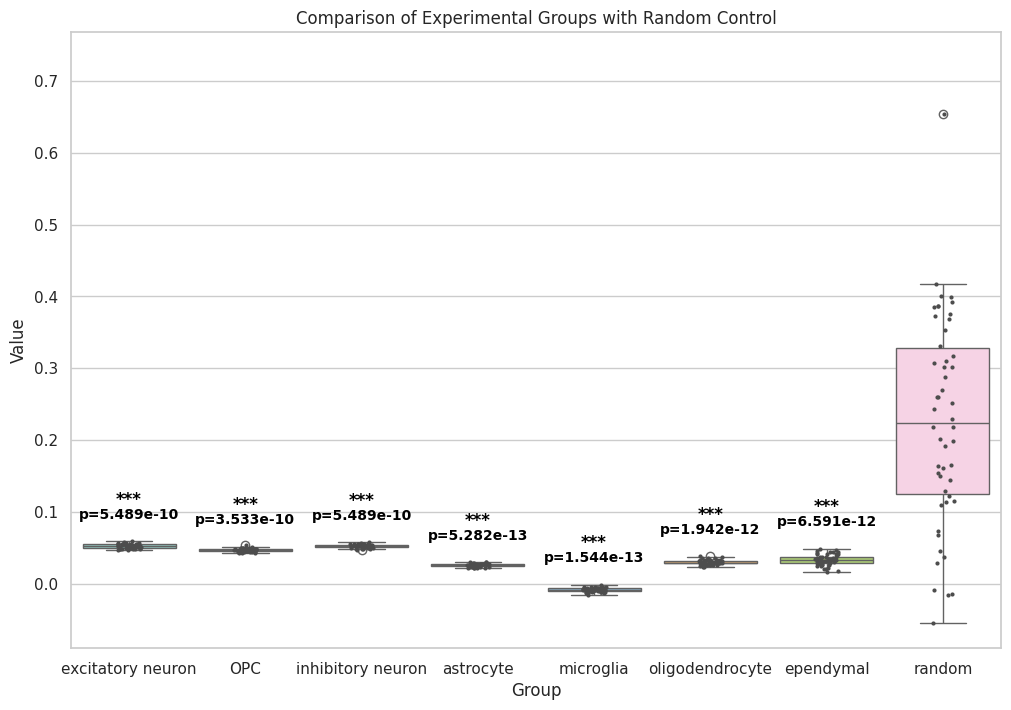

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums

# 假设 df 是你的 DataFrame
# df = pd.read_csv('your_data.csv')  # 根据实际情况加载数据

# 对照组数据位于第9列（索引为8）
control_group = df.iloc[:, 7]

# 存储结果
results = []

# 循环遍历前8列实验组数据（索引0到7）
for i in range(7):
    experiment_group = df.iloc[:, i]
    # 执行秩和检验
    stat, p_value = ranksums(experiment_group, control_group)
    results.append({'Column': df.columns[i], 'Statistic': stat, 'P-value': p_value})

# 将结果转换为 DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv('celltype_raw_score_p_value.csv')

# 设置绘图风格
sns.set(style="whitegrid")

# 创建一个新的DataFrame用于绘图
df_melted = df.iloc[:, :8].melt(id_vars=[], value_vars=[f'{df.columns[i]}' for i in range(7)] + ['random'],
                                var_name='Group', value_name='Value')

# 绘制箱线图并获取轴对象
plt.figure(figsize=(12, 8))
box_plot = sns.boxplot(x='Group', y='Value', data=df_melted, palette="Set3")

# 添加散点图以显示原始数据点，并减小点的大小
sns.stripplot(x='Group', y='Value', data=df_melted, color=".3", jitter=True, size=3)  # 减小点的大小

# 计算位置信息并添加 p 值和显著性标记
positions = range(len(df.columns)-1)  # 获取分组数量
for idx, result in enumerate(results_df.itertuples()):
    p_value = result[3]
    if p_value < 0.001:
        significance = "***"
    elif p_value < 0.01:
        significance = "**"
    elif p_value < 0.05:
        significance = "*"
    else:
        significance = ""

    # 使用 box_plot 数据计算上边缘位置
    group_data = df[df.columns[idx]]
    q1, med, q3 = group_data.quantile([0.25, 0.5, 0.75])
    upper_whisker = min(q3 + 1.5 * (q3 - q1), group_data.max())

    # 在箱子的上边缘之上一点添加 p 值
    box_plot.text(positions[idx], upper_whisker + (box_plot.get_ylim()[1] - box_plot.get_ylim()[0]) * 0.04,
                  f"p={p_value:.3e}", horizontalalignment='center', size='small', color='black', weight='semibold')
    
    # 在 p 值之上添加显著性标记
    box_plot.text(positions[idx], upper_whisker + (box_plot.get_ylim()[1] - box_plot.get_ylim()[0]) * 0.065,
                  significance, horizontalalignment='center', size='medium', color='black', weight='bold')

# 调整y轴范围确保文本不会超出图像边界
box_plot.set_ylim(box_plot.get_ylim()[0], box_plot.get_ylim()[1] + (box_plot.get_ylim()[1] - box_plot.get_ylim()[0]) * 0.1)

# 显示图形
plt.title('Comparison of Experimental Groups with Random Control')
plt.show()

/tmp/ipykernel_2934495/4251597729.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='Group', y='Value', data=df_melted, palette="Set3")


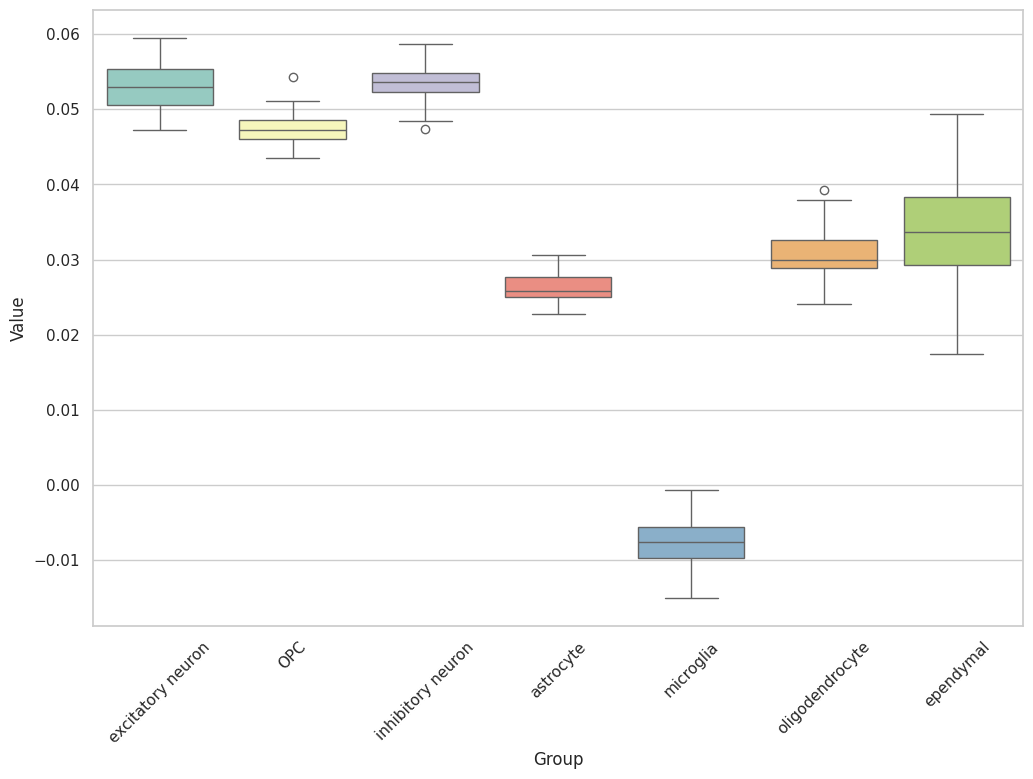

In [18]:
# 创建一个新的DataFrame用于绘图
plt.figure(figsize=(12, 8))

df_melted = df.iloc[:, :7].melt(id_vars=[], value_vars=[f'{df.columns[i]}' for i in range(7)] ,
                                var_name='Group', value_name='Value')

box_plot = sns.boxplot(x='Group', y='Value', data=df_melted, palette="Set3")


plt.xticks(rotation = 45)
plt.show()

In [29]:
hmdata = sc.read_h5ad('hmdata_full_harmony.h5ad')

total_res = []


species_keylist = ['CY','JT','T','QF','M']
celltype_list = hmdata.obs.celltype.unique()

"""
data sample
"""
res = {}
for celltype_key in celltype_list:
    subdata = hmdata[hmdata.obs.celltype == celltype_key]
    centroid_list = []
    for species_key in species_keylist:
        scdata = subdata[subdata.obs.species == species_key]#.raw.to_adata()

        idx = np.arange(scdata.shape[0])
        sel_idx = np.random.choice(idx, size = 100)

        meta_cell = scdata[sel_idx,:].obsm['X_pca_harmony'].mean(axis = 0)
        meta_cell = scdata[sel_idx,:].X.toarray().mean(axis = 0)
        centroid_list.append(meta_cell)

    centroid_data = np.array(centroid_list)
    
    # 使用pdist计算行与行之间的欧式距离，结果是一个一维数组，包含了所有成对距离
    pairwise_dist = pdist(centroid_data, metric='euclidean')

    # 使用squareform将上述的一维数组转换为方阵形式，即距离矩阵
    tmp = squareform(pairwise_dist)
    a1 = (tmp[:3,:3].sum() - 3)/6
    a2 = (tmp[3:,3:].sum() - 2)/2
    a3 = (tmp[3:,:3]).sum()/6 
    score = (a1+a2)/2 - a3
    res[celltype_key] = (a1,a2,a3,score) 


    ### add celltype random control 
    centroid_list = []
    for species_key in species_keylist:
        scdata = hmdata[hmdata.obs.species == species_key]#.raw.to_adata()

        idx = np.arange(scdata.shape[0])
        sel_idx = np.random.choice(idx, size = 100)

        meta_cell = scdata[sel_idx,:].obsm['X_pca_harmony'].mean(axis = 0)
        #meta_cell = scdata[sel_idx,:].X.toarray().mean(axis = 0)
        centroid_list.append(meta_cell)

    centroid_data = np.array(centroid_list)
    #tmp = np.corrcoef(centroid_data)
    # 使用pdist计算行与行之间的欧式距离，结果是一个一维数组，包含了所有成对距离
    pairwise_dist = pdist(centroid_data, metric='euclidean')

    # 使用squareform将上述的一维数组转换为方阵形式，即距离矩阵
    tmp = squareform(pairwise_dist)
    a1 = (tmp[:3,:3].sum())/6
    a2 = (tmp[3:,3:].sum())/2
    a3 = (tmp[3:,:3]).sum()/6 
    score = (a1+a2)/2 - a3
    res['random'] =  (a1,a2,a3,score) 


In [23]:
import numpy as np
from scipy.spatial.distance import pdist, squareform


# 使用pdist计算行与行之间的欧式距离，结果是一个一维数组，包含了所有成对距离
pairwise_dist = pdist(centroid_data, metric='euclidean')

# 使用squareform将上述的一维数组转换为方阵形式，即距离矩阵
distance_matrix = squareform(pairwise_dist)

print(distance_matrix)

[[ 0.          3.66728035  7.97128273 15.7211553   7.40233787]
 [ 3.66728035  0.          6.07579373 14.87518498  6.04178847]
 [ 7.97128273  6.07579373  0.         13.80281356  5.37117162]
 [15.7211553  14.87518498 13.80281356  0.         11.51146893]
 [ 7.40233787  6.04178847  5.37117162 11.51146893  0.        ]]


In [31]:
tmp

array([[ 0.        ,  3.07831458,  6.15859533, 17.63615641,  8.49923748],
       [ 3.07831458,  0.        ,  5.39974413, 16.2270709 ,  7.93149834],
       [ 6.15859533,  5.39974413,  0.        , 15.01918285,  5.72580402],
       [17.63615641, 16.2270709 , 15.01918285,  0.        , 12.34165667],
       [ 8.49923748,  7.93149834,  5.72580402, 12.34165667,  0.        ]])

In [30]:
pd.DataFrame(res)

,excitatory neuron,random,OPC,inhibitory neuron,astrocyte,microglia,oligodendrocyte,ependymal
0,43.374989,4.878885,40.024696,41.307526,40.461698,40.473874,37.654276,37.607150
1,33.708714,12.341657,38.017479,33.217842,39.554704,40.470641,36.669711,33.176438
2,46.241639,11.839825,45.472832,42.417457,43.172358,40.831355,40.198877,38.225069
3,-7.699787,-3.229554,-6.451744,-5.154773,-3.164157,-0.359098,-3.036884,-2.833275
